# Energy A.I. Hackathon 2025 Workflow - deepblue

#### Authors: 
1. Stepan Tretiakov, Walker Department of Mechanical Engineering
1. Samuel Mercer, McKetta Department of Chemical Engineering
1. Bugart Lan, Walker Department of Mechanical Engineering
1. Shreya Vignesh, Hildebrand Department of Petroleum Engineering
1. Enow Tanyi, Hildebrand Department of Petroleum Engineering
#### The University of Texas at Austin, Austin, Texas, USA 
___

### Executive Summary 

1. What is the problem: Wells for hydraulic fracturing depend on many variables that have uncertainty. 
2. What did your team do to address the problem: The deepblue team developed a predictive machine learning algorithm that accounts for uncertainty in feature data relevant to hydraulic fracturing wells to accurately forecast minimum energy consumption. 
3. What did your team learn: We learned that the Field Area, the Ambient Temperature, and Estimated Average Stage Time capture the relevant character of required energy consumption for fracturing jobs. 
4. What does your team recommend going forward: We recommend a comprehensive evaluation of the subsurface field area and the required number of stages to properly predict the energy consumption by well. 

___

### Workflow Goal

To develop a predictive machine learning algorithm that forecasts the energy usage of grid, diesel, and CNG fuel sources during hydraulic fracturing operations. 
___

### Workflow Steps 

Enumerated steps, very short and concise overview of our methods and workflow

1. **Data Analysis** - feature imputation, one hot encoding, standard scalar, random forest regression to handle missing values in both train and test dataset. Interpolation to handle missing values in training dataset.
2. **Feature Selection** - binary classification, random forest regression
3. **Machine Learning Model** - random forest regression, random forest classifier, stacking regressor
4. **Handling Uncertainty** - bootstrapping, adding noise

### Import Packages

In [6]:
import numpy as np                                      # model arrays
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # building plots
import seaborn as sns                                   
import os                                               # accessing the operating system

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingRegressor
from sklearn.metrics import r2_score, mean_squared_error, classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.svm import SVR

### Load Data

The following workflow applies the .csv file 'HackathonData2025.csv'. 

We will work with the following features:

* **Number of Stages** - the number of stages that the well was completed with. 
* **Estimated Average Stage Time** - The time the stage takes to complete, estimated by dividing the total volume of slurry that the stage requires by the average rate that the slurring is pumped at. 
* **Fleet Type** - zipper or simul
* **Target Formation** - the layer of rock being fractured. 
* **Field Area** - the geographic placement of the well. 
* **Ambient Temperature** - the average temperature (in F) during fracturing. 
* **Grid** - the energy consumption of the well using electricity (in kWh)
* **Diesel** - the energy consumption of the well using diesel (in gallons)
* **CNG** - the energy consumption of the well using CNG (in MMBTUs)
* **Fuel Type** - the type of fuel that the fuel fleet used at a well. 
* **Sand Provider** - the company that provided sand to be pumped into the well. 

### Functions

The following functions will be used in the workflow.

In [8]:
def plot_corr(dataframe,size=10):                       # plots a correlation matrix as a heat map 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='left')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

def pair_plot_generator(dataframe, field_element_string, categorical_string):
    df_subset = dataframe[dataframe["Field Area"] == field_element_string]
    df_subset.drop('Field Area', axis=1, inplace=True)
    pair_plot_fig = sns.pairplot(dataframe[['Well Name', '# Stages', '# Clusters ', 'Estimated Average Stage Time',
       'Actual Average Stage Time', 'Frac Fleet', 'Fleet Type',
       'Target Formation', 'Ambient Temperature', 'Grid',
       'Diesel', 'CNG', 'Fuel Type', 'Sand Provider ']], hue=categorical_string, corner=True);
    
    return pair_plot_fig
    
def field_area_subset(dataframe, string, formationtype):
    df_subset = dataframe[dataframe["Field Area"] == string]
    df_subset.drop('Field Area', axis=1, inplace=True)
    groupSubset = df_subset.groupby(['Target Formation']).value_counts()[formationtype]
    countsSubset = groupSubset.sum()
    return countsSubset


In [9]:
my_data = pd.read_csv("HackathonData2025.csv")         # load the correct data file
my_data = my_data.iloc[:,1:]  

# Select only numeric columns for correlation
numeric_data = my_data.select_dtypes(include=[np.number])

### Basic Data Checking and Visualization

* in the figures below, we evaluated the plots/tables to determine the number of missing variables and the correlations between variables. 

* we eliminated the number of clusters from the model as we considered that it was captured by the number of stages. 

* we noticed there was significantly more data for CNG and Diesel compared to Grid. As such, we took a note for overfitting.

Dataset Shape: (1082, 14)

Columns: ['# Stages', '# Clusters ', 'Estimated Average Stage Time', 'Actual Average Stage Time', 'Frac Fleet', 'Fleet Type', 'Target Formation', 'Field Area', 'Ambient Temperature', 'Grid', 'Diesel', 'CNG', 'Fuel Type', 'Sand Provider ']

Numeric Columns: ['# Stages', '# Clusters ', 'Estimated Average Stage Time', 'Actual Average Stage Time', 'Ambient Temperature', 'Grid', 'Diesel', 'CNG']

Basic Statistics:
          # Stages  # Clusters   Estimated Average Stage Time  \
count  1082.000000  1082.000000                    914.000000   
mean     57.371534   400.095194                     96.762691   
std      13.401390    98.232442                     21.529890   
min      31.000000   177.000000                     47.100000   
25%      50.000000   325.000000                     76.200000   
50%      51.000000   378.500000                     96.000000   
75%      68.000000   480.750000                    106.700000   
max     101.000000   734.000000         

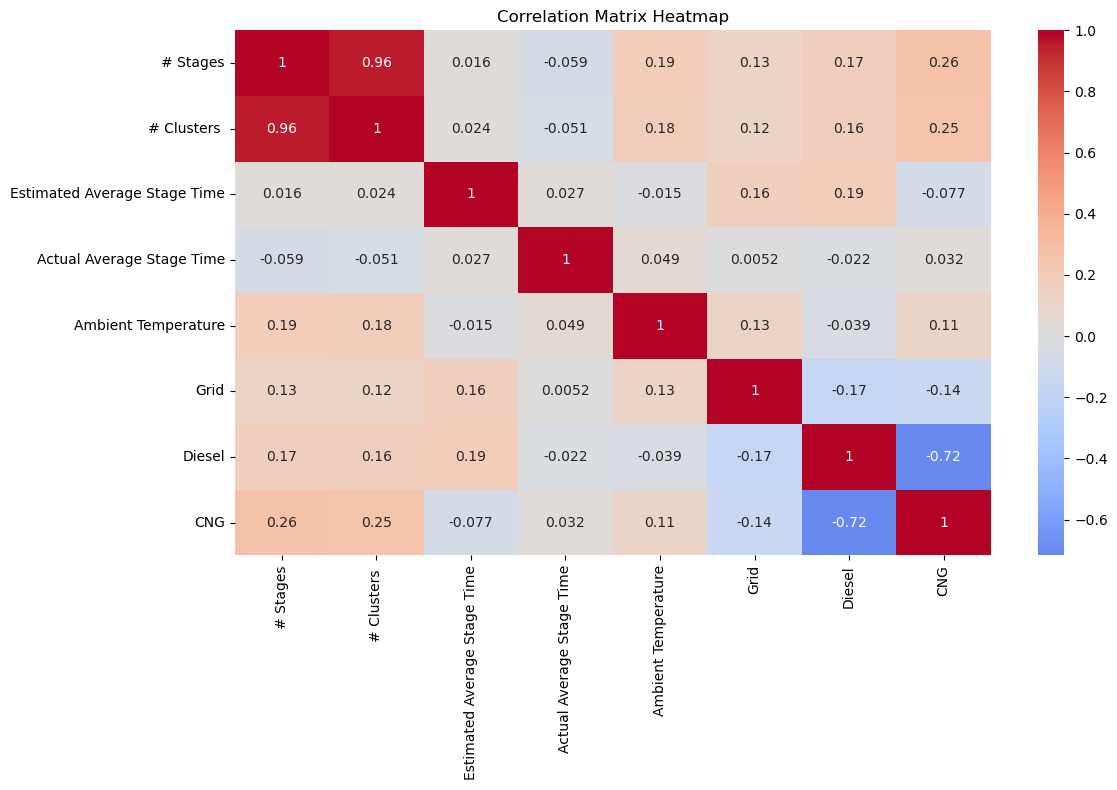

In [10]:
# Basic data exploration
print("Dataset Shape:", my_data.shape)
print("\nColumns:", my_data.columns.tolist())

# Select only numeric columns for correlation and statistics
numeric_columns = my_data.select_dtypes(include=[np.number]).columns
print("\nNumeric Columns:", numeric_columns.tolist())

print("\nBasic Statistics:")
print(my_data[numeric_columns].describe())

# Check for missing values
print("\nMissing Values:")
print(my_data.isnull().sum())

# Create correlation matrix heatmap with better formatting
plt.figure(figsize=(12, 8))
correlation_matrix = my_data[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

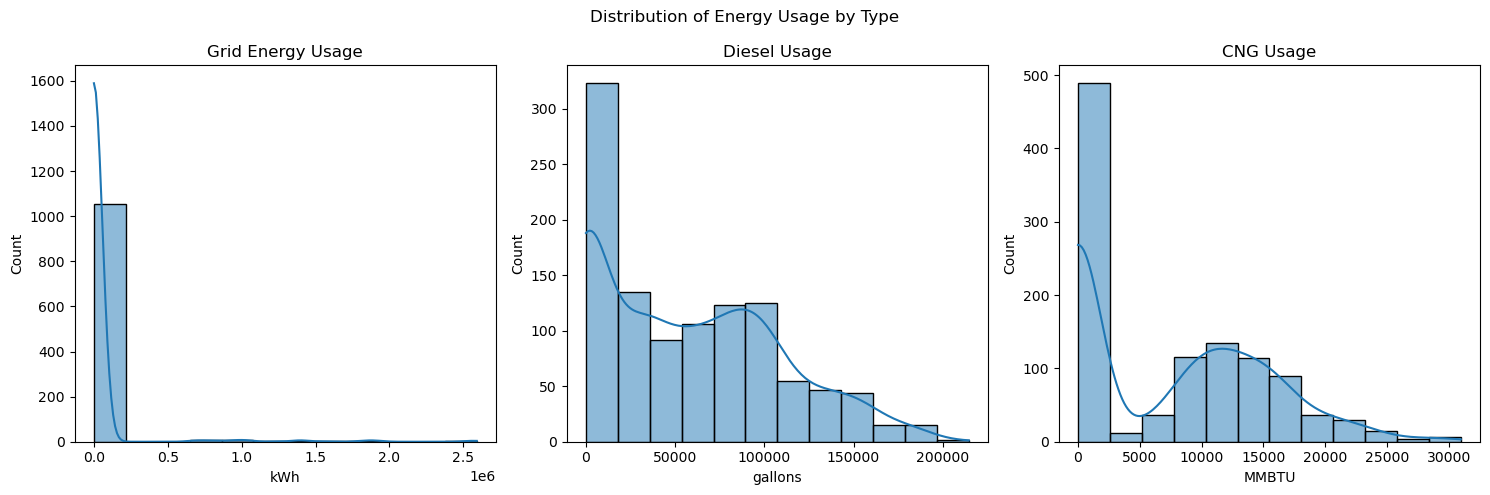

In [11]:
# Distribution plots for key energy metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Distribution of Energy Usage by Type')

sns.histplot(data=my_data['Grid'].dropna(), ax=axes[0], kde=True)
axes[0].set_title('Grid Energy Usage')
axes[0].set_xlabel('kWh')
sns.histplot(data=my_data['Diesel'].dropna(), ax=axes[1], kde=True)
axes[1].set_title('Diesel Usage')
axes[1].set_xlabel('gallons')

sns.histplot(data=my_data['CNG'].dropna(), ax=axes[2], kde=True)
axes[2].set_title('CNG Usage')
axes[2].set_xlabel('MMBTU')

plt.tight_layout()
plt.show()

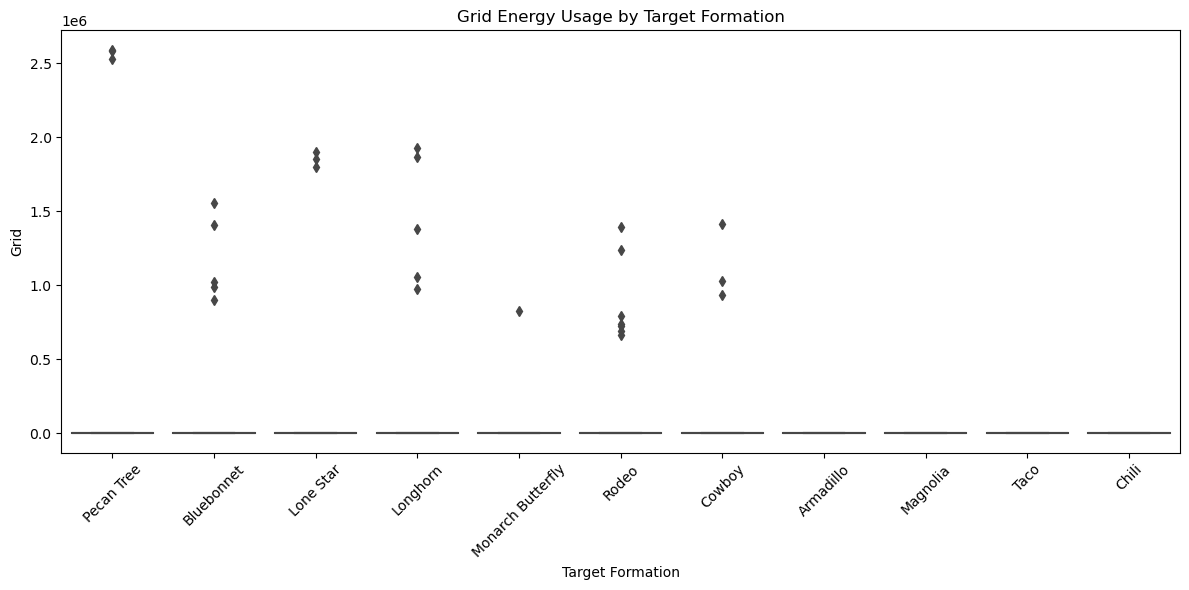


Average Energy Usage by Fuel Type:
                   Grid         Diesel           CNG
Fuel Type                                           
DGB        0.000000e+00   39718.611111  11720.925926
Diesel     0.000000e+00  106644.061002      0.000000
Grid       1.361075e+06       0.000000      0.000000
Turbine    0.000000e+00       0.000000  15339.220588


In [12]:
# Box plots for energy usage by Target Formation
plt.figure(figsize=(12, 6))
sns.boxplot(x='Target Formation', y='Grid', data=my_data)
plt.xticks(rotation=45)
plt.title('Grid Energy Usage by Target Formation')
plt.tight_layout()
plt.show()

# Analysis by Fuel Type
print("\nAverage Energy Usage by Fuel Type:")
print(my_data.groupby('Fuel Type')[['Grid', 'Diesel', 'CNG']].mean())

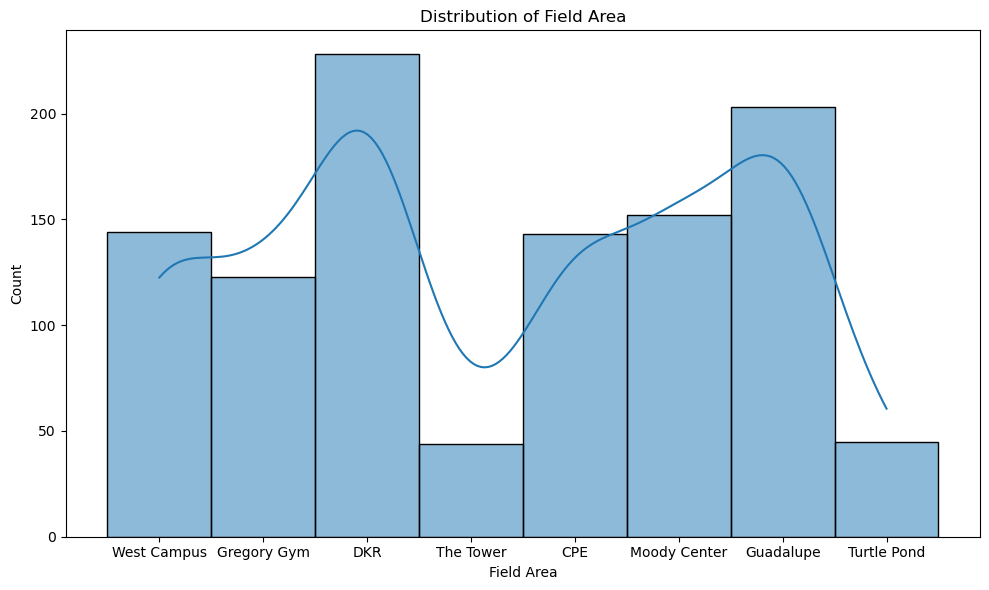


Rows with missing Fleet Type (selected columns):
    Fleet Type    Field Area   Target Formation  Grid
15         NaN     The Tower         Bluebonnet     0
16         NaN     The Tower         Bluebonnet     0
448        NaN  Moody Center         Bluebonnet     0
449        NaN  Moody Center         Bluebonnet     0
450        NaN  Moody Center         Bluebonnet     0
451        NaN  Moody Center  Monarch Butterfly     0
452        NaN  Moody Center  Monarch Butterfly     0
530        NaN           CPE              Rodeo     0
531        NaN           CPE              Rodeo     0


In [13]:
# Distribution plot for Field Area
plt.figure(figsize=(10, 6))
sns.histplot(data=my_data['Field Area'].dropna(), kde=True)
plt.title('Distribution of Field Area')
plt.xlabel('Field Area')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print selected columns for rows with missing Fleet Type
print("\nRows with missing Fleet Type (selected columns):")
selected_columns = ['Fleet Type', 'Field Area', 'Target Formation', 'Grid']  # add any other columns you want to see
print(my_data[my_data['Fleet Type'].isna()][selected_columns])

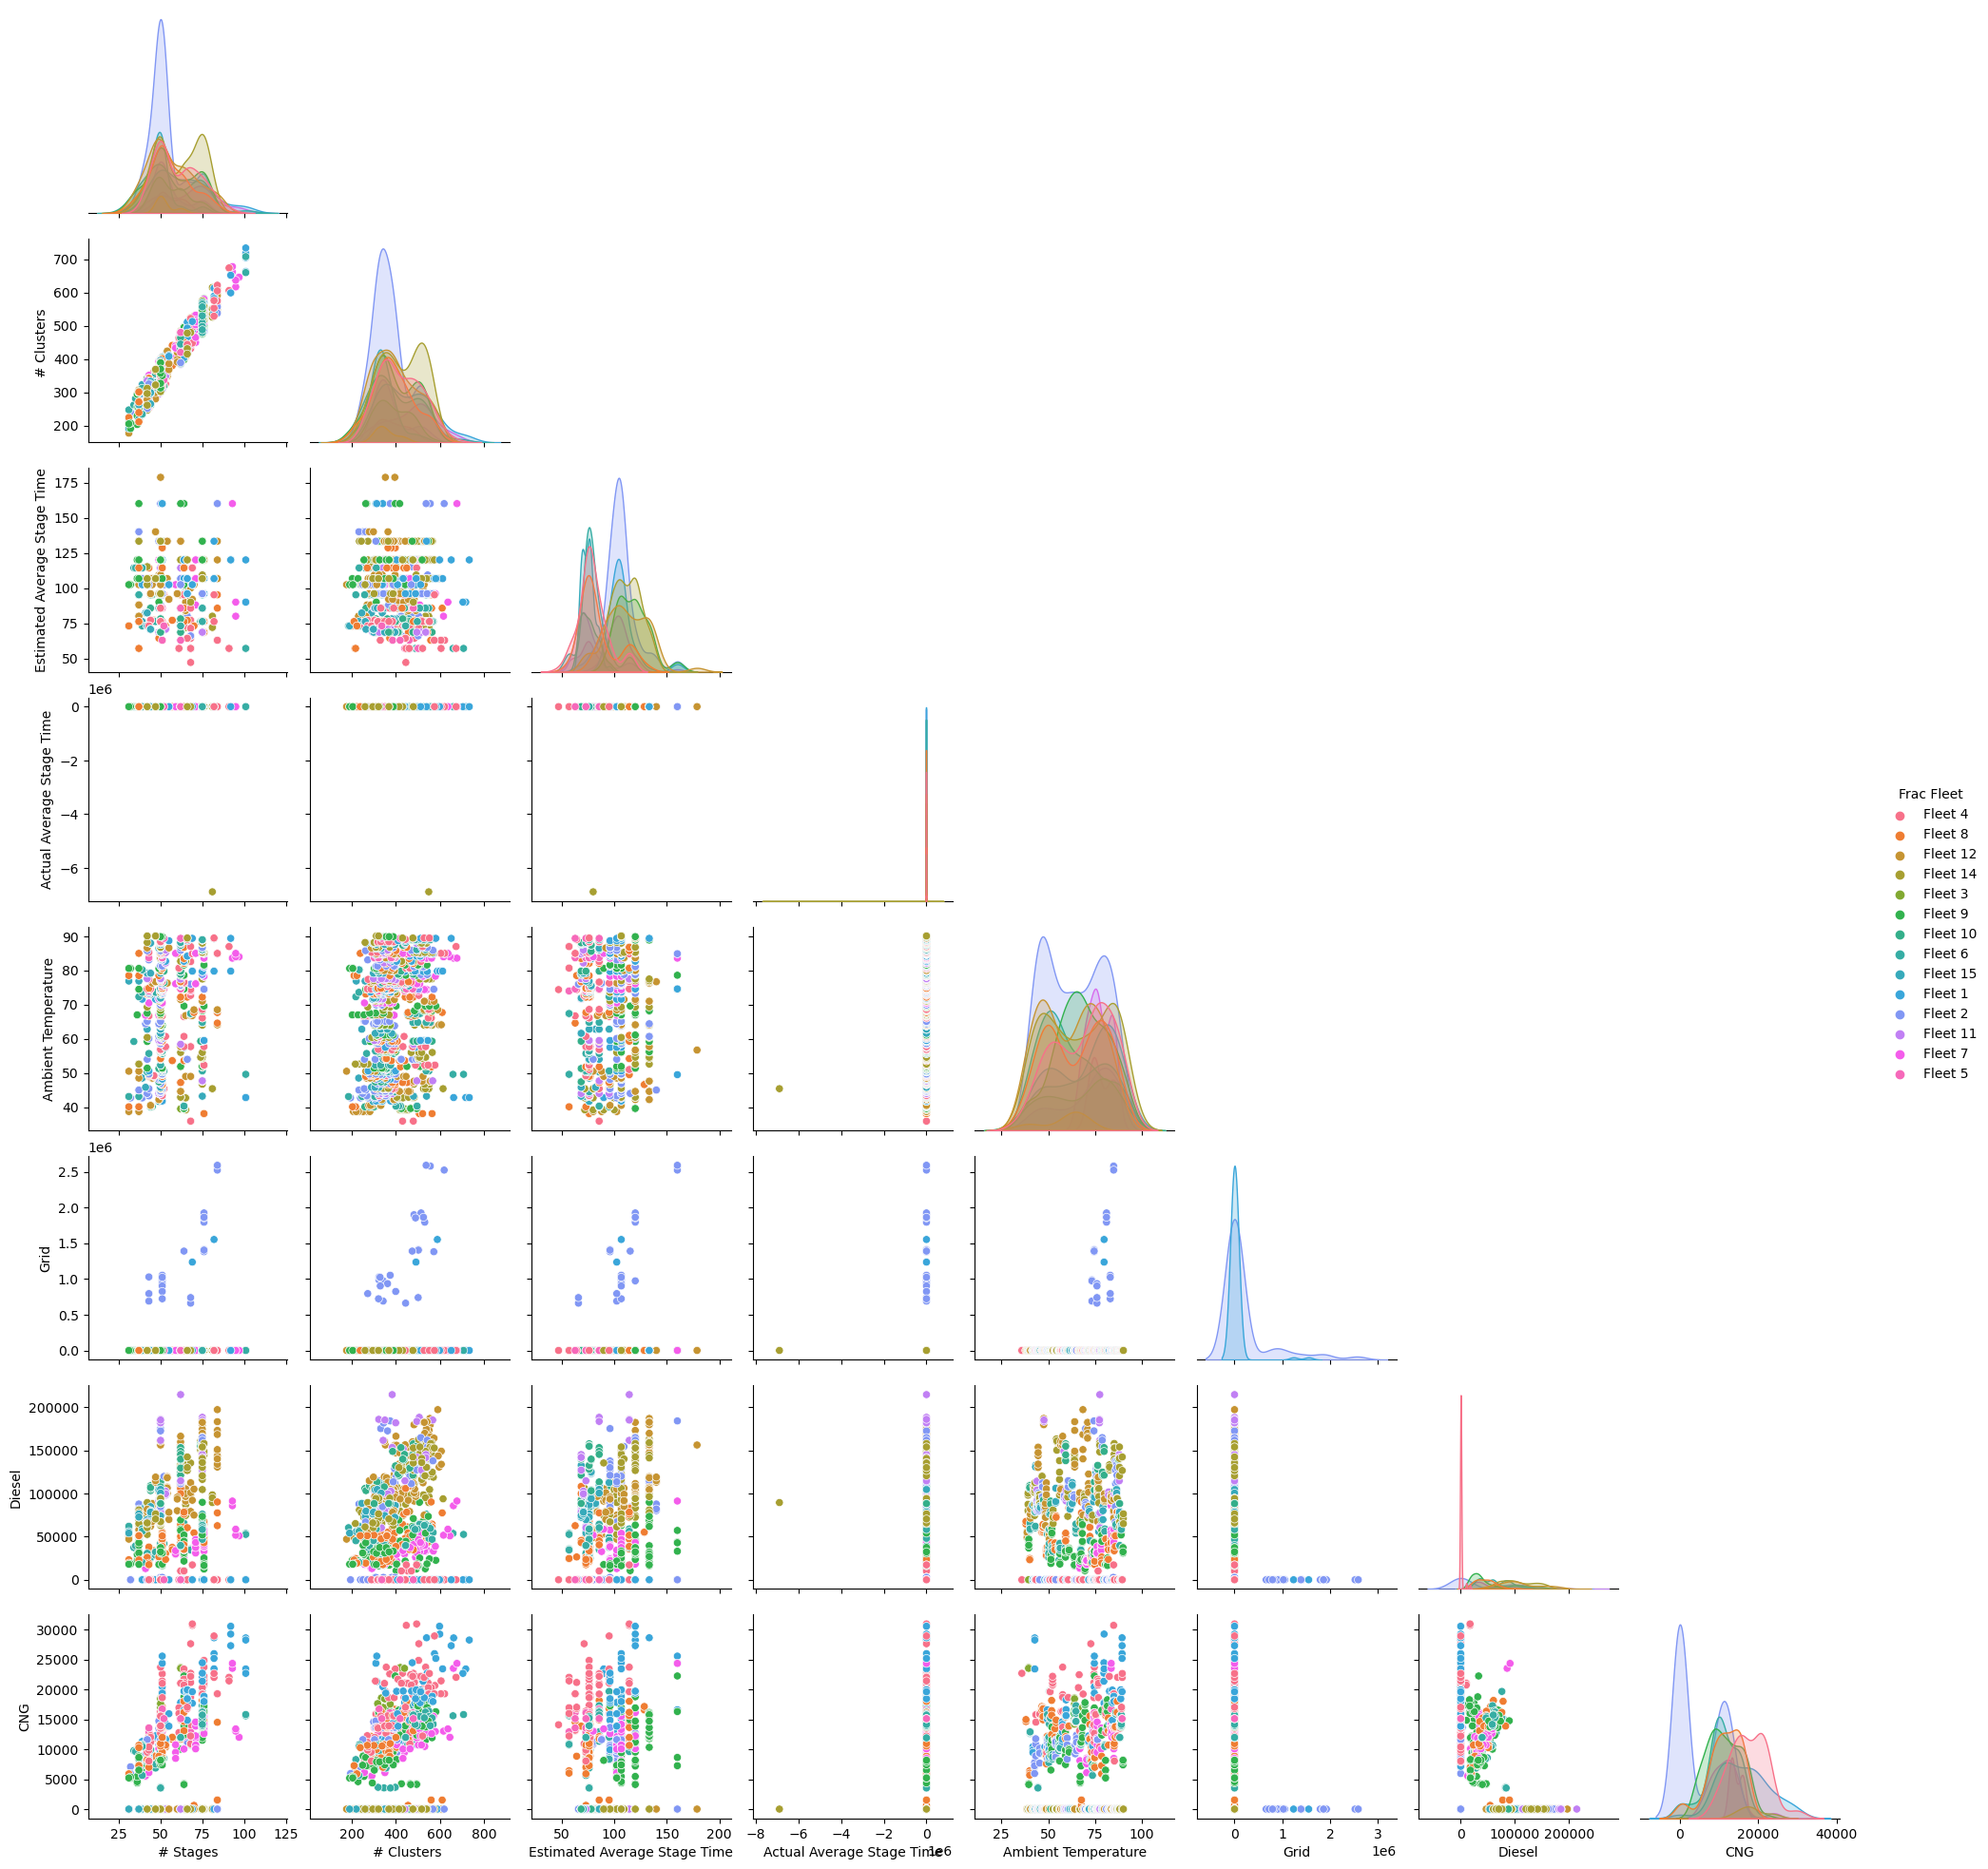

In [17]:
sns.pairplot(my_data[['# Stages', '# Clusters ', 'Estimated Average Stage Time',
       'Actual Average Stage Time', 'Frac Fleet', 'Fleet Type',
       'Target Formation', 'Ambient Temperature', 'Grid',
       'Diesel', 'CNG', 'Fuel Type', 'Sand Provider ']], hue='Frac Fleet', corner=True);

(<Figure size 3000x2400 with 3 Axes>,
 {('West Campus', 'Pecan Tree'): (0.0,
   0.0,
   0.1285863537732058,
   0.12096774193548386),
  ('West Campus', 'Bluebonnet'): (0.0,
   0.12419354838709676,
   0.1285863537732058,
   0.23521505376344087),
  ('West Campus', 'Lone Star'): (0.0,
   0.3626344086021505,
   0.1285863537732058,
   0.05376344086021502),
  ('West Campus', 'Longhorn'): (0.0,
   0.41962365591397843,
   0.1285863537732058,
   0.2217741935483871),
  ('West Campus', 'Monarch Butterfly'): (0.0,
   0.6446236559139784,
   0.1285863537732058,
   0.04032258064516125),
  ('West Campus', 'Rodeo'): (0.0,
   0.6881720430107526,
   0.1285863537732058,
   0.1612903225806452),
  ('West Campus', 'Cowboy'): (0.0,
   0.8526881720430107,
   0.1285863537732058,
   0.09408602150537632),
  ('West Campus', 'Armadillo'): (0.0,
   0.95,
   0.1285863537732058,
   0.04032258064516125),
  ('West Campus', 'Magnolia'): (0.0,
   0.9935483870967741,
   0.1285863537732058,
   0.0),
  ('West Campus', 'Taco')

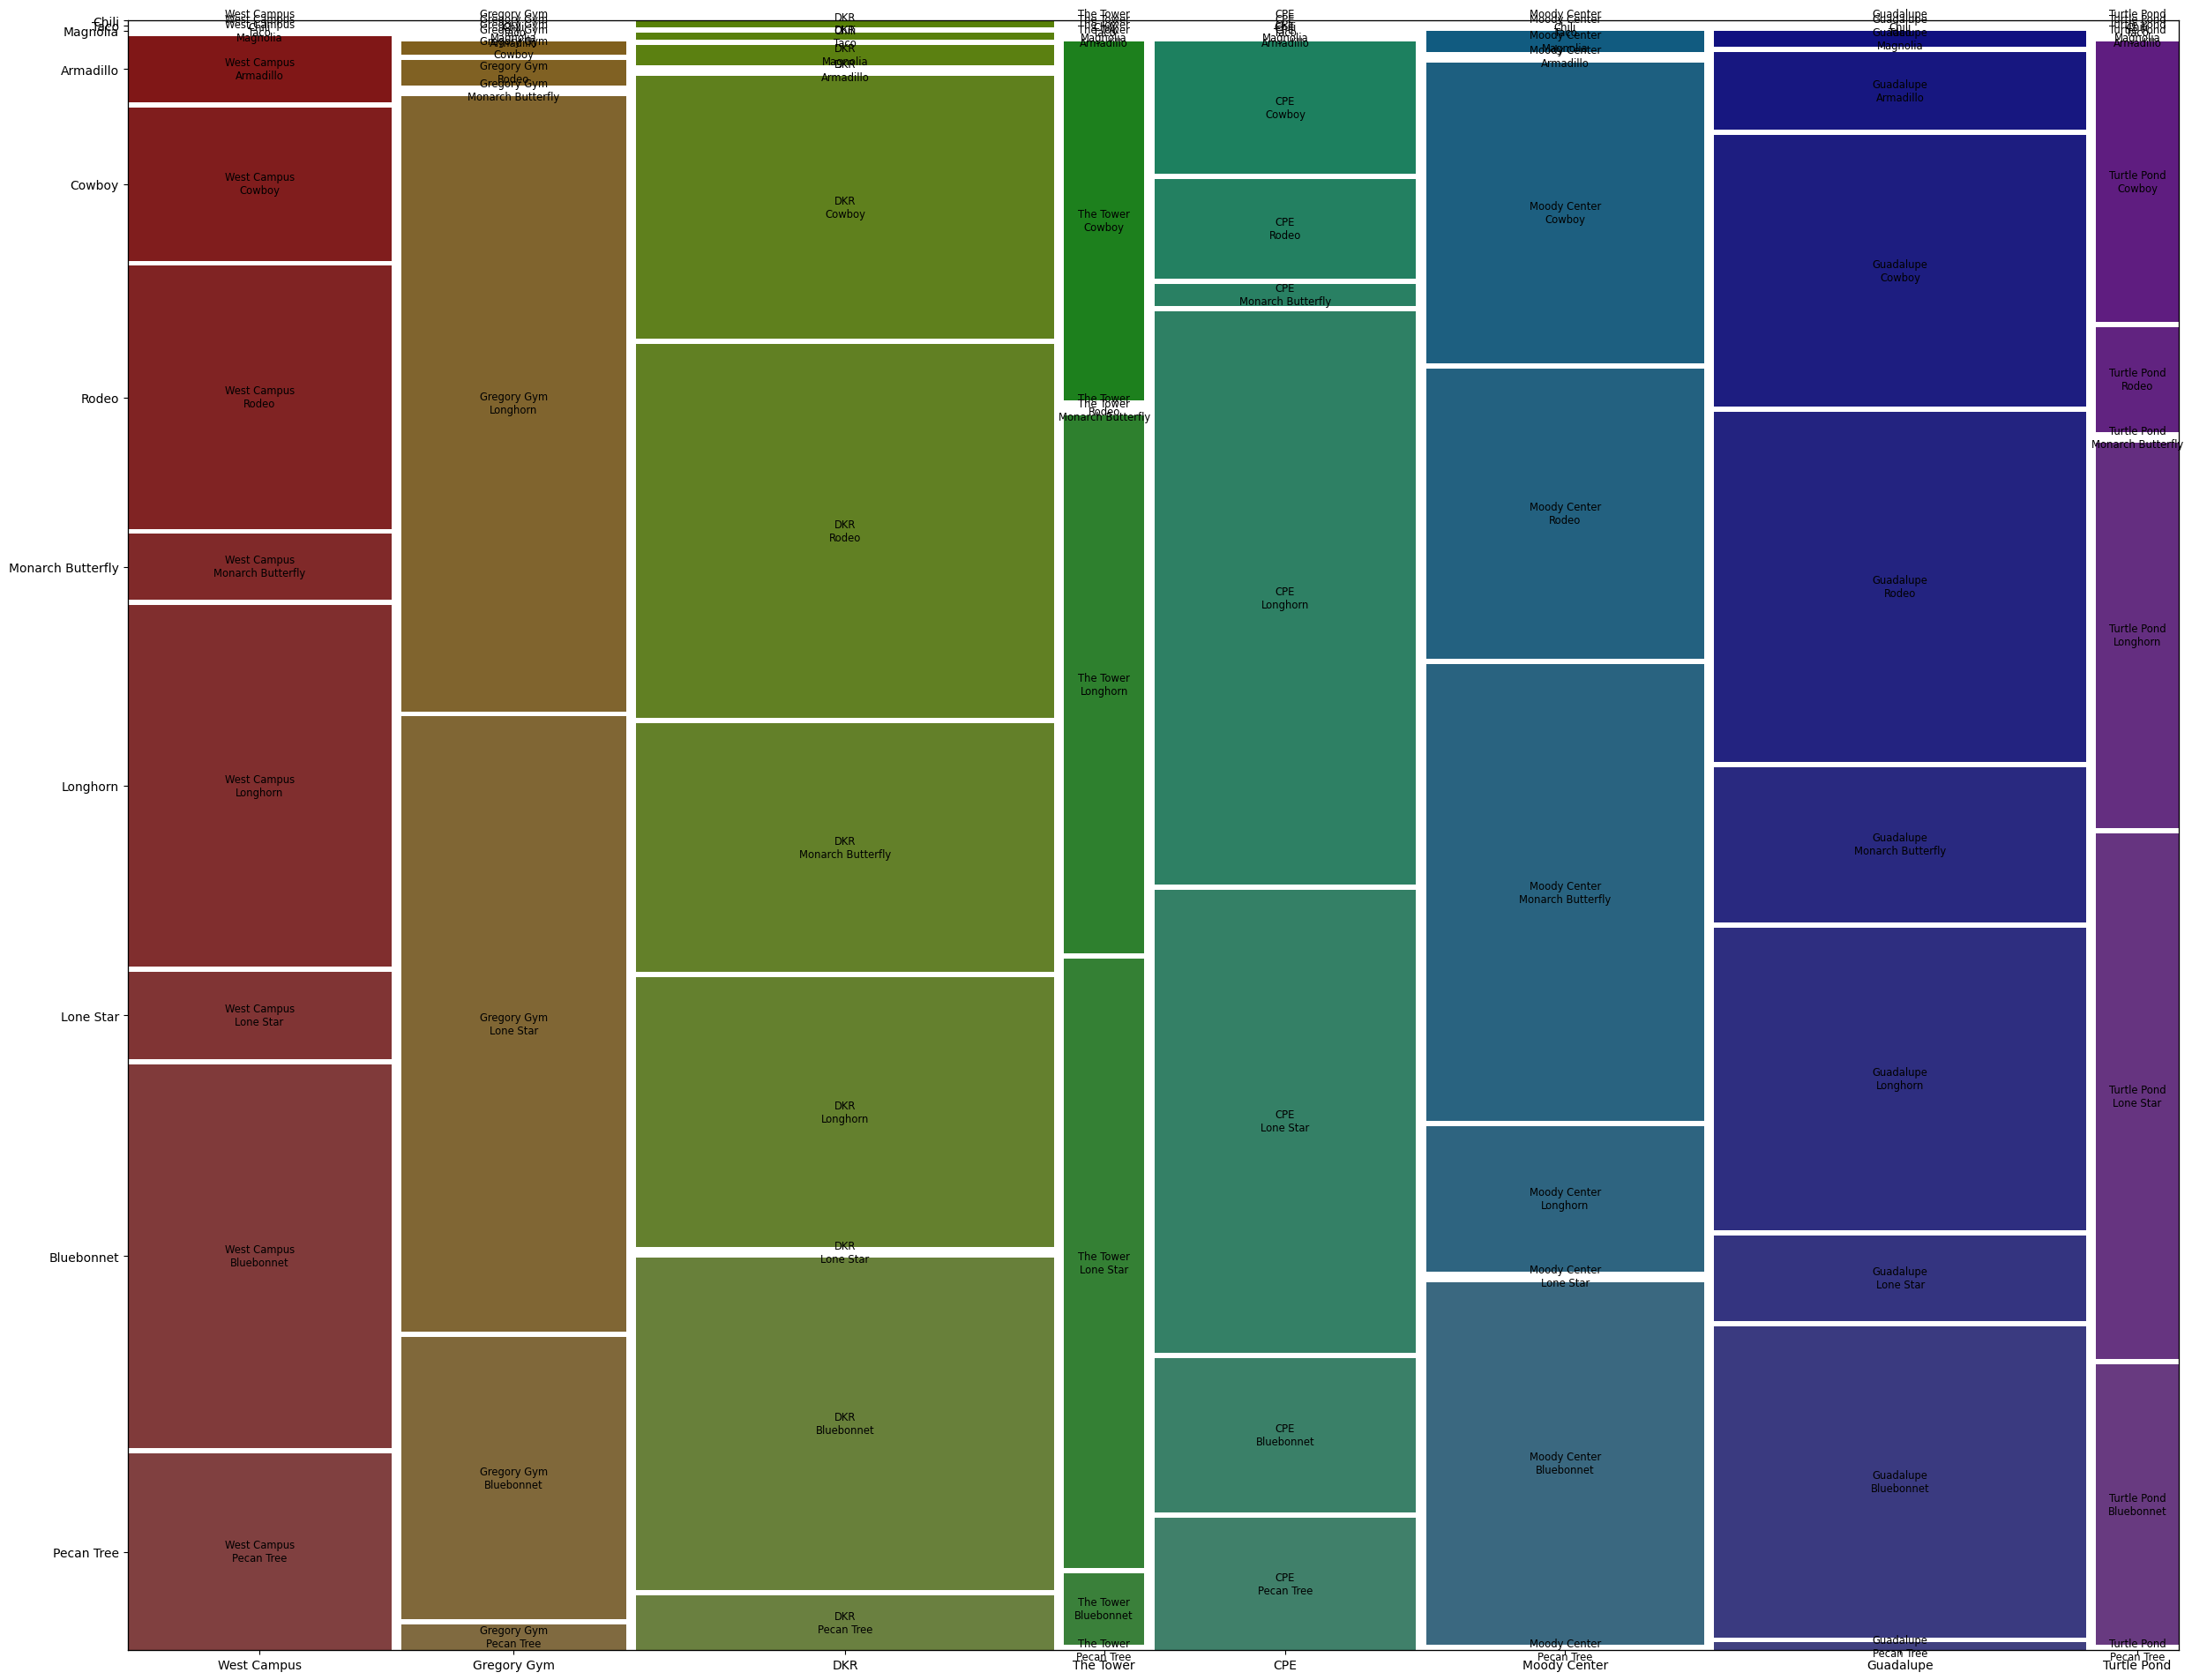

In [19]:
from statsmodels.graphics.mosaicplot import mosaic

fig, ax = plt.subplots(figsize=(30, 24))
mosaic(my_data, ['Field Area', 'Target Formation'], ax=ax)

### Data Imputation
* from the missing values above, the categorical variables were first considered followed by the numerical variables. 

* within the **Handle_missingData.py** file, one-hot encoding was used to analyze the categorical data and impute the missing Fleet Types. 

* a new .csv file was generated as **HackathonData2025+Fleet_Type_units_AT.csv**, containing the one-hot encoding. 

* the numerical variables used the updated .csv file to impute: (1) ambient temperature and (2) estimated average stage time. The ambient temperature was linearly interpolated. 

* the estimated average stage time was imputed using Random Forest Regression within the **RandomForest_handle_missing_time.py** file.

* the output .csv file with the completed recovered data was **TrainData_recovered_forest.csv**.

### Feature Selection
* following the completion of data imputation, the columns 'Actual Average Stage Time' and 'Sand Provider' were dropped based on the feature importance plot below. They were ruled as unimportant to the training data.

* the most important features were the Field Area, Estimated Average Stage Time, and Ambient Temperature.

* three separate model files - **ModelCNG.py**, **ModelDiesel.py**, **ModelGrid.py** - were used for training.

* during feature selection, a RandomForestClassifier was applied with Binary Classification. 

* a StandardScalar() was used to scale the features for regression.

Text(0.5, 0, 'Relative Importance')

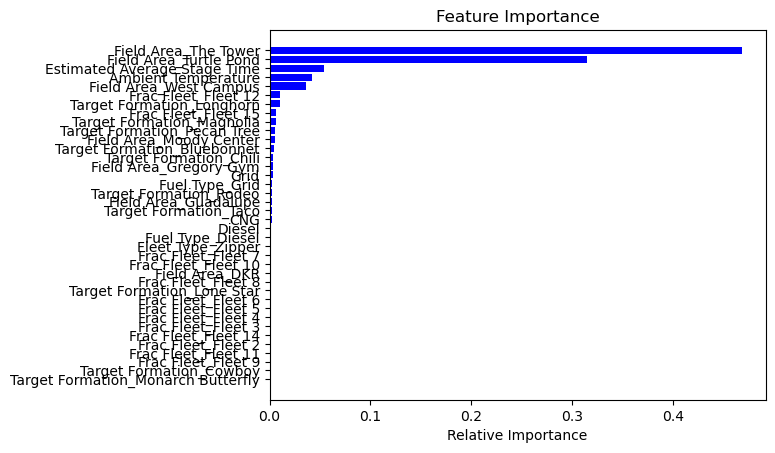

In [20]:
#df = pd.read_csv('TrainData_with_recovered_estimated_time.csv')
df_time = pd.read_csv('TrainData_recovered_forest_main.csv')
df = pd.read_csv('TrainData_with_recovered_estimated_time.csv')
df_clean = df.drop('Actual Average Stage Time', axis=1)
df_clean['Estimated Average Stage Time'] = df_time['Estimated Average Stage Time']
n = len(df_clean.columns)
X = df_clean.loc[:,(df_clean.columns != "Grid") & (df_clean.columns != "Diesel") & (df_clean.columns != "CNG")].to_numpy()
y = df_clean.iloc[:,2:5].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
randreg = RandomForestRegressor()
randreg.fit(X_train,y_train)
features = df_clean.columns[:-1]
importances = randreg.feature_importances_
indices = np.argsort(importances)
plt.figure(3) #the axis number
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

### Fixing the Testing File

* the testing file had a number of missing values. 

* the **Recover_temp_test.py** file was developed to impute the missing ambient temperature data. 

* the **RandomForest_handle_missing_time.py** file was again used to impute missing estimated stage time data

* the output for the fixed data set was **testing_with_filled_temperatures.csv** data

### Uncertainty Quantification

* using the **TrainData_recovered_forest.csv** test set, an uncertainty analysis was conducted using the bootstrapping method.

* independent uncertainty analyses was conducted for each fuel type in the following files: **Grid_uncet.py**, **Diesel_uncet.py**, **CNG_uncet.py**
    
* a similar workflow as before was used by (1) pre-processing data through one-hot encoding and standard scaling, (2) applying binary classification on the training and testing data with Random Forest Classification.

* next, a baseline regression was predicted. We processed external test data in the **testing_with_filled_temperatures.csv** file.

* 100 bootstrap realizations were created, where each iteration sampled training data with replacement, trained the classifier, trained the regressor on a non-zero subset, predicted an external test, added noise for non-zero predictions. 

* the bootstraps are done sequentially to generate the **test_main_predictions.csv** file. 

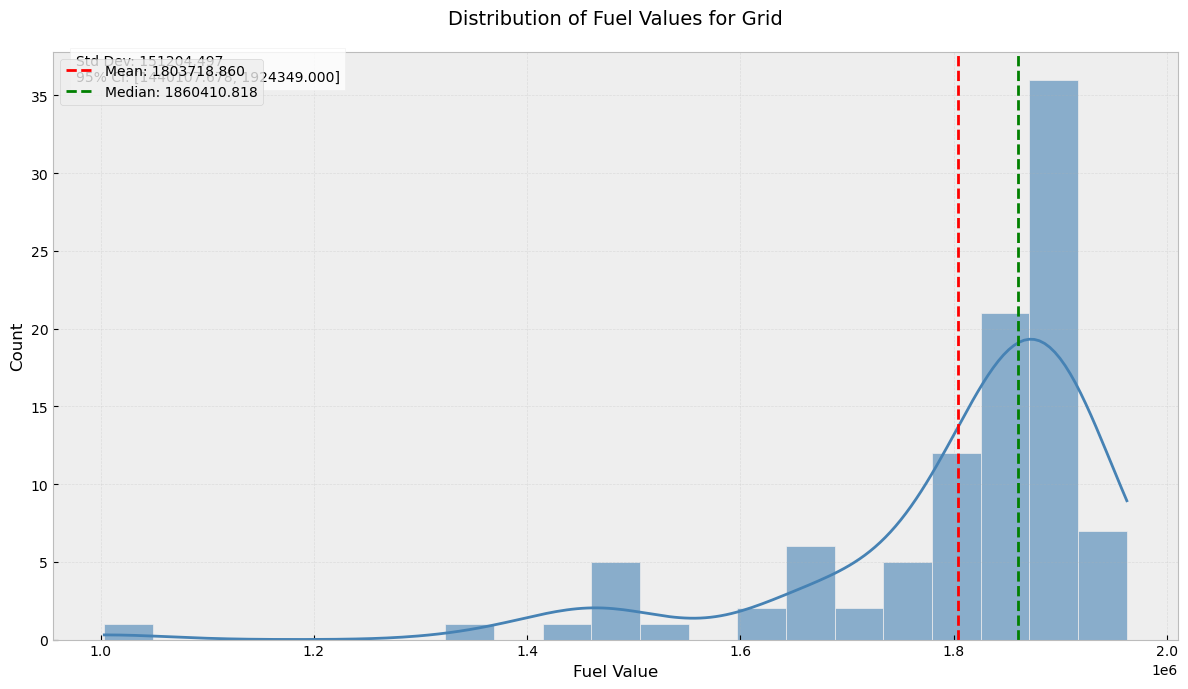

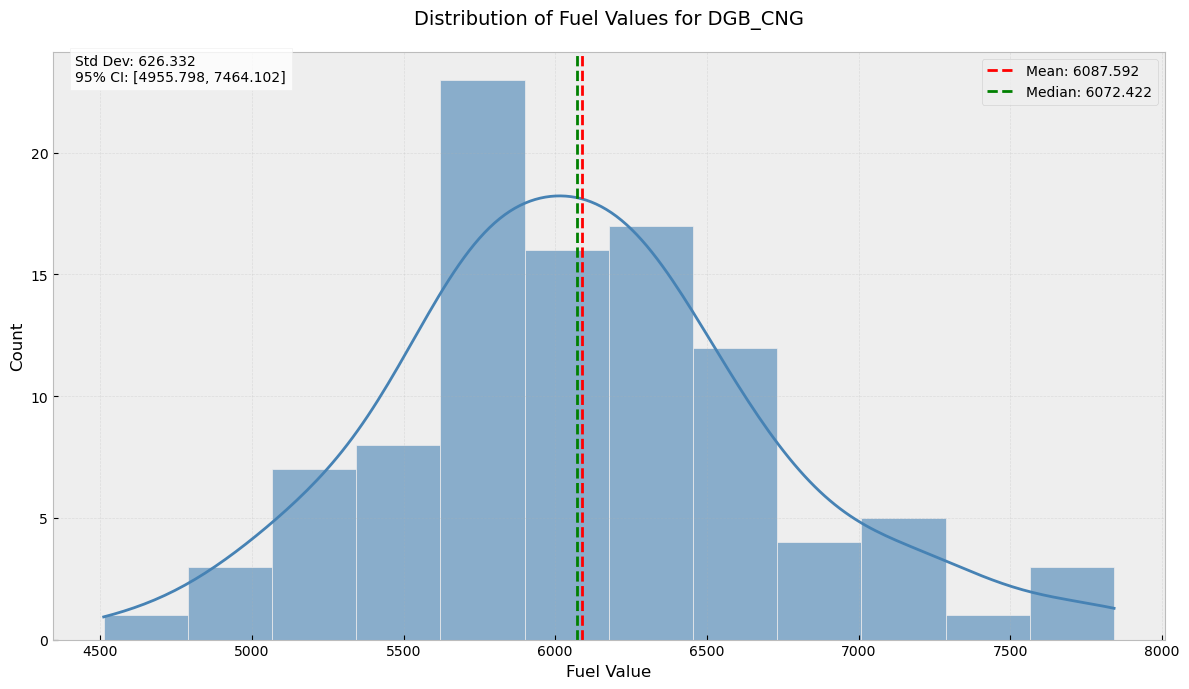

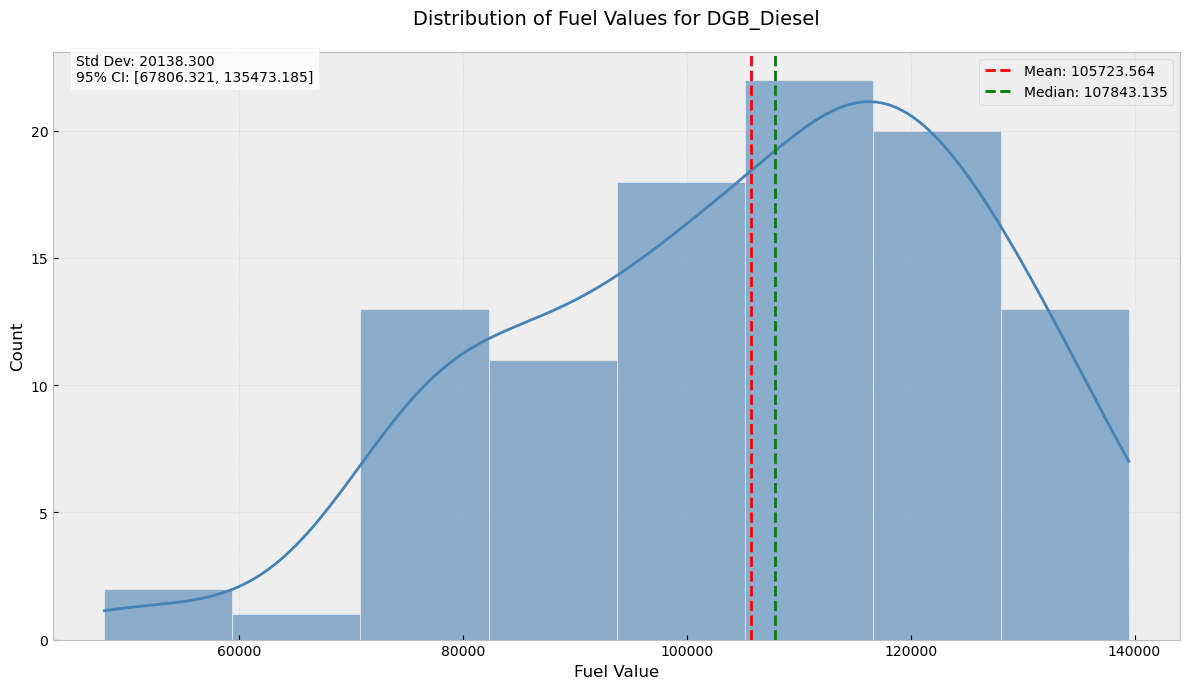

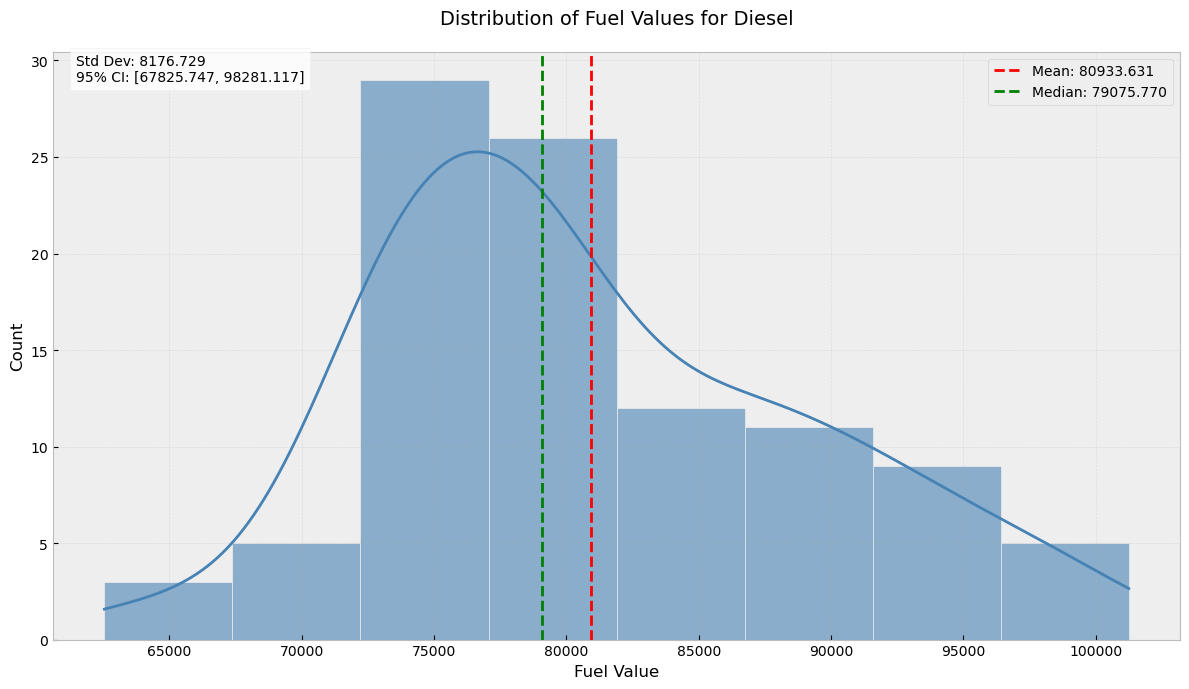

In [23]:
# Set the style for better-looking plots
plt.style.use('bmh')
sns.set_palette("husl")

# Read the CSV with bootstrap predictions
df = pd.read_csv("solution_3.csv")

# Get R columns and fuel types
r_columns = [col for col in df.columns if col.startswith('R_')]
fuel_types = df['Fuel Type'].unique()

# Create separate plots for each fuel type
for idx, fuel in enumerate(fuel_types):
    # Skip the third plot (index 2)
    if idx == 2:
        continue
        
    plt.figure(figsize=(12, 7))
    
    # Get data for current fuel type - just the first row
    fuel_data = df[df['Fuel Type'] == fuel].iloc[0][r_columns]
    
        # Plot distribution with improved styling
    sns.histplot(fuel_data, kde=True, color='steelblue', alpha=0.6)
    
    # Add mean and median lines
    plt.axvline(np.mean(fuel_data), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(fuel_data):.3f}')
    plt.axvline(np.median(fuel_data), color='green', linestyle='dashed', linewidth=2, label=f'Median: {np.median(fuel_data):.3f}')
    
    # Add statistical information
    plt.text(0.02, 0.95, 
             f'Std Dev: {np.std(fuel_data):.3f}\n'
             f'95% CI: [{np.percentile(fuel_data, 2.5):.3f}, {np.percentile(fuel_data, 97.5):.3f}]',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.title(f'Distribution of Fuel Values for {fuel}', fontsize=14, pad=20)
    plt.xlabel('Fuel Value', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend()
    
    # Adjust layout and display
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save the plot instead of displaying it
    filename = f'distribution_{fuel.replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

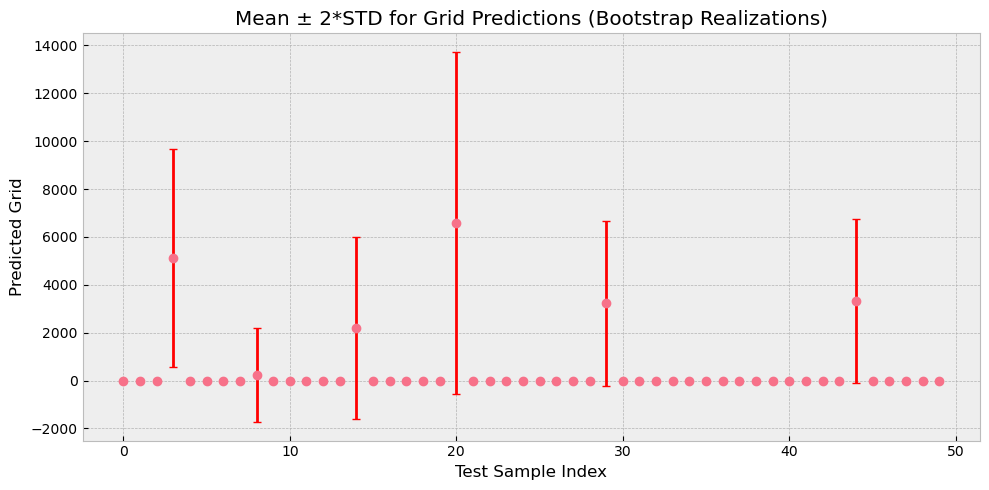

In [25]:
# Read the CSV with bootstrap predictions
df = pd.read_csv("test_uncert_predictions.csv")

# Identify the columns that store our 100 bootstrap realizations
g_cols = [c for c in df.columns if c.startswith('G')]
# Extract them as a NumPy array of shape (num_samples_in_test, 100)
pred_matrix = df[g_cols].values

# Compute summary statistics across the 100 realizations
pred_mean = np.mean(pred_matrix, axis=1)  # shape = (num_samples_in_test,)
pred_std  = np.std(pred_matrix, axis=1)   # shape = (num_samples_in_test,)

# Plot: mean predictions vs. sample index, with ±2 std as error bars
plt.figure(figsize=(10, 5))
plt.errorbar(
    x=range(len(pred_mean)),
    y=pred_mean,
    yerr=2 * pred_std,
    fmt='o',  # 'o' for circle markers
    ecolor='red',
    capsize=3
)
plt.title("Mean ± 2*STD for Grid Predictions (Bootstrap Realizations)")
plt.xlabel("Test Sample Index")
plt.ylabel("Predicted Grid")
plt.tight_layout()
plt.show()


row_index = 0  # or any other test sample index
sample_preds = pred_matrix[row_index, :]  # All 100 predictions for that row

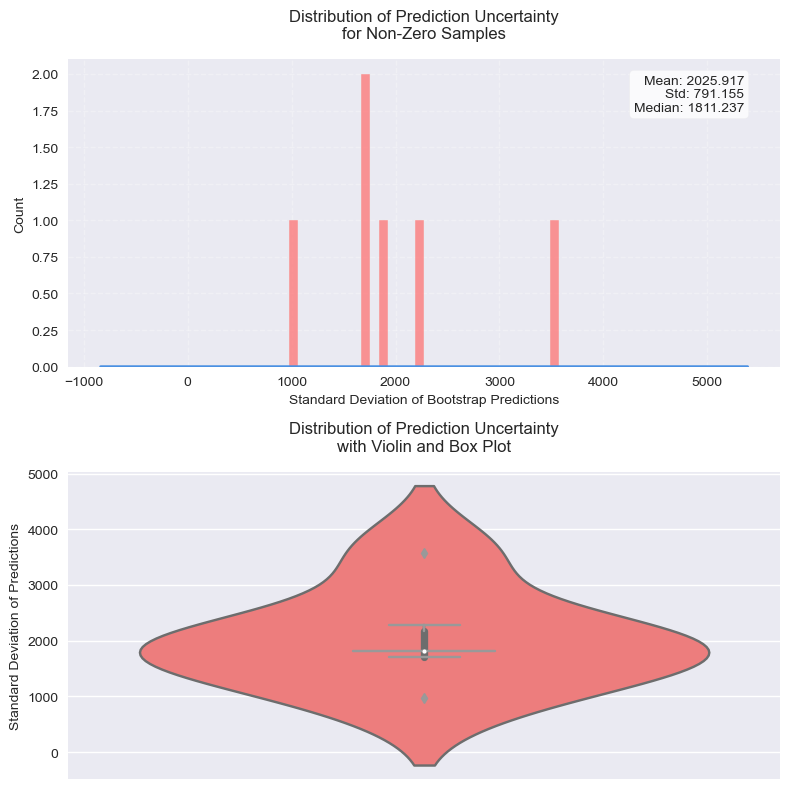

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load your test set predictions (with D1..D100)
df = pd.read_csv("test_uncert_predictions.csv")

# 2. Identify columns with bootstrap predictions
g_cols = [col for col in df.columns if col.startswith('G')]
pred_matrix = df[g_cols].values  # shape: (n_test_samples, 100)

# 3. Compute mean and std across columns (per test sample)
pred_mean = np.mean(pred_matrix, axis=1)
pred_std  = np.std(pred_matrix, axis=1)

# 4. Create a mask for "non-zero" samples
#    Method A: Use 'mean > 0' (only include rows with a strictly positive mean)
# nonzero_mask = (pred_mean > 0)

#    Method B: Include any row where *at least one* of the 100 predictions is non-zero
nonzero_mask = np.any(pred_matrix != 0, axis=1)

# Filter down to non-zero samples
nonzero_std = pred_std[nonzero_mask]

# 5. Plot the distribution with improved styling
plt.style.use('seaborn-v0_8')  # Updated style name
# OR alternatively use:
# plt.style.use('seaborn-darkgrid')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Histogram with KDE
sns.histplot(data=nonzero_std, bins=30, color='#FF6B6B', alpha=0.7, ax=ax1)
sns.kdeplot(data=nonzero_std, color='#4A90E2', linewidth=2, ax=ax1)

ax1.set_title("Distribution of Prediction Uncertainty\nfor Non-Zero Samples", 
              fontsize=12, pad=15)
ax1.set_xlabel("Standard Deviation of Bootstrap Predictions", fontsize=10)
ax1.set_ylabel("Count", fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')

# Add summary statistics annotation
stats_text = f'Mean: {nonzero_std.mean():.3f}\nStd: {nonzero_std.std():.3f}\nMedian: {np.median(nonzero_std):.3f}'
ax1.text(0.95, 0.95, stats_text,
         transform=ax1.transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Enhanced boxplot with violin plot
sns.violinplot(y=nonzero_std, color='#FF6B6B', alpha=0.7, ax=ax2)
sns.boxplot(y=nonzero_std, color='white', width=0.2, 
           showfliers=True, fliersize=5, ax=ax2)

ax2.set_title("Distribution of Prediction Uncertainty\nwith Violin and Box Plot", 
              fontsize=12, pad=15)
ax2.set_ylabel("Standard Deviation of Predictions", fontsize=10)

plt.tight_layout()
plt.show()  # Close the figure to free memory

### Solution File

* The file **GetSolution.py** utilizes the **test_main_predictions.csv** to generate a scaled solution set for **scaled_solution.csv**. 
* The file **FinalGetSol.py** utilizes  **scaled_solution.csv** to generate the **solution.csv** dataset.